In [1]:
import os
import torchaudio
import torch
from torchmetrics import SignalNoiseRatio
import matplotlib.pyplot as plt
from torch.nn import Module,Sigmoid,LSTM, Linear, BCELoss, MSELoss, Conv1d, Conv2d, MaxPool2d, Transformer, LayerNorm, PReLU, Fold, ConvTranspose1d, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import random
from torchmetrics import ScaleInvariantSignalNoiseRatio
import pickle
import math

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# import DataLoader

# X,Y,speech,noise,mix,stft_mix = DataLoader.data_loader(n_noise=1)
import DataLoaderOne
stfts_mix,trainY,speech,mix1 = DataLoaderOne.data_loader()

torch.Size([513, 196])
torch.Size([513, 196])
torch.Size([513, 196])


In [3]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)



In [7]:
# TRANSFORMER MASK NET
NUMBER_OF_SPEAKERS = 4
ENCODED_TIMESTEPS = int(50000/8) # 50000 is len of training data -> 50000/8 = 6250
FOLDS = int((ENCODED_TIMESTEPS/250)*2-1)
FILTERS = 256
D_TF = 1024#1024

class TransformerMaskNet(Module):
    def __init__(self,noise=False):
        super(TransformerMaskNet, self).__init__()
        # ENCODER subnet
        self.tdnn = Conv1d(in_channels=1,out_channels=256,kernel_size=16,stride=8,padding=6)

        self.lnorm = LayerNorm(normalized_shape=(ENCODED_TIMESTEPS))
        self.lin0 = Linear(in_features=256, out_features=256)

        self.pe = PositionalEncoding(d_model=196)
        #self.pe2 = PositionalEncoding(d_model=250)
        self.ln11 = LayerNorm(normalized_shape=(513,196))
        self.ln12 = LayerNorm(normalized_shape=(513,196))
        self.ln21 = LayerNorm(normalized_shape=(513,196))
        self.ln22 = LayerNorm(normalized_shape=(513,196))
        self.ln31 = LayerNorm(normalized_shape=(513,196))
        self.ln32 = LayerNorm(normalized_shape=(513,196))
        self.ln41 = LayerNorm(normalized_shape=(513,196))
        self.ln42 = LayerNorm(normalized_shape=(513,196))
        # self.ln51 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln52 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln61 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln62 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln71 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln72 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln81 = LayerNorm(normalized_shape=(FOLDS,250))
        # self.ln82 = LayerNorm(normalized_shape=(FOLDS,250))

        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha3 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha4 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        # self.mha5 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        # self.mha6 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        # self.mha7 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        # self.mha8 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)

        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf2 = Linear(in_features=196,out_features=D_TF)
        self.lintf3 = Linear(in_features=196,out_features=D_TF)
        self.lintf4 = Linear(in_features=196,out_features=D_TF)
        # self.lintf5 = Linear(in_features=250,out_features=D_TF)
        # self.lintf6 = Linear(in_features=250,out_features=D_TF)
        # self.lintf7 = Linear(in_features=250,out_features=D_TF)
        # self.lintf8 = Linear(in_features=250,out_features=D_TF)
        self.lintf12 = Linear(in_features=D_TF,out_features=196)
        self.lintf22 = Linear(in_features=D_TF,out_features=196)
        self.lintf32 = Linear(in_features=D_TF,out_features=196)
        self.lintf42 = Linear(in_features=D_TF,out_features=196)
        # self.lintf52 = Linear(in_features=D_TF,out_features=250)
        # self.lintf62 = Linear(in_features=D_TF,out_features=250)
        # self.lintf72 = Linear(in_features=D_TF,out_features=250)
        # self.lintf82 = Linear(in_features=D_TF,out_features=250)

        self.prelu = PReLU()
        self.lin1 = Linear(in_features=196, out_features=(196))

        # self.fold = Fold(output_size=(1,ENCODED_TIMESTEPS),kernel_size=(1,250),stride=(1,125))
        self.lin2 = Linear(in_features=196, out_features=196)
        self.lin3 = Linear(in_features=NUMBER_OF_SPEAKERS, out_features=2)
        self.sigmoid = Sigmoid()
        # self.convT = ConvTranspose1d(in_channels=256,out_channels=1,kernel_size=16,stride=8, padding=4)

        #self.tf1 = Transformer(d_model = 256, nhead=8, dim_feedforward=1024)
        #self.tf2 = Transformer(d_model = 256, nhead=8, dim_feedforward=1024)
        # SEPFORMER Block
        # y = self.tf1(x,torch.rand(250,FOLDS,256))
        # x = y + x
        # y = self.tf2(x,torch.rand(250,FOLDS,256))
        # x = y + x # Residual connection
        self.lstm = LSTM(input_size=4, hidden_size=64, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=128 ,out_features=1)

    def forward(self,x):

        x = x.reshape(NUMBER_OF_SPEAKERS,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x
        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        # Transformer 3
        y = self.pe(x)
        z = self.ln31(y)
        z, _ = self.mha3(z,z,z)
        z_2 = z+y
        z = self.ln32(z_2)
        z = self.lintf3(z)
        z = F.relu(z)
        z = self.lintf32(z)
        x = z+z_2+x
        # Transformer 4
        y = self.pe(x)
        z = self.ln41(y)
        z, _ = self.mha4(z,z,z)
        z_2 = z+y
        z = self.ln42(z_2)
        z = self.lintf4(z)
        z = F.relu(z)
        z = self.lintf42(z)
        x = z+z_2+x

        # # PERMUTATION
        # x = x.view(256,FOLDS,250)

        # # Transformer 5
        # y = self.pe2(x)
        # z = self.ln51(y)
        # z, _ = self.mha5(z,z,z)
        # z_2 = z+y
        # z = self.ln52(z_2)
        # z = self.lintf5(z)
        # z = F.relu(z)
        # z = self.lintf52(z)
        # x = z+z_2+x
        # # Transformer 6
        # y = self.pe2(x)
        # z = self.ln61(y)
        # z, _ = self.mha6(z,z,z)
        # z_2 = z+y
        # z = self.ln62(z_2)
        # z = self.lintf6(z)
        # z = F.relu(z)
        # z = self.lintf62(z)
        # x = z+z_2+x
        # # Transformer 7
        # y = self.pe2(x)
        # z = self.ln71(y)
        # z, _ = self.mha7(z,z,z)
        # z_2 = z+y
        # z = self.ln72(z_2)
        # z = self.lintf7(z)
        # z = F.relu(z)
        # z = self.lintf72(z)
        # x = z+z_2+x
        # # Transformer 8
        # y = self.pe2(x)
        # z = self.ln81(y)
        # z, _ = self.mha8(z,z,z)
        # z_2 = z+y
        # z = self.ln82(z_2)
        # z = self.lintf8(z)
        # z = F.relu(z)
        # z = self.lintf82(z)
        # x = z+z_2+x

        # PRELU and Linear
        x = self.prelu(x)
        x = x.view(NUMBER_OF_SPEAKERS,513,196)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = x.view(513,196,NUMBER_OF_SPEAKERS)
        #x = self.lin3(x)
        x = F.relu(x)

        x = x.view(513,196,NUMBER_OF_SPEAKERS)
        y, (h_n, c_n) = self.lstm(x)
        x = self.fc(y)
        x = self.sigmoid(x).view(513,196)
        return x
    

print(summary(TransformerMaskNet(),torch.zeros((4, 513, 196))))

---------------------------------------------------------------------------------------------------------
            Layer (type)                                    Output Shape         Param #     Tr. Param #
    PositionalEncoding-1                                   [4, 513, 196]               0               0
             LayerNorm-2                                   [4, 513, 196]         201,096         201,096
    MultiheadAttention-3                      [4, 513, 196], [513, 4, 4]         154,448         154,448
             LayerNorm-4                                   [4, 513, 196]         201,096         201,096
                Linear-5                                  [4, 513, 1024]         201,728         201,728
                Linear-6                                   [4, 513, 196]         200,900         200,900
             LayerNorm-7                                   [4, 513, 196]         201,096         201,096
    MultiheadAttention-8                      [4, 513,

In [5]:
EPOCHS = 30
BATCH_SIZE = 1
INIT_LR = 0.00001 #0.001 is too high
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFmask'
TRS = 0.5

CUDA = True # if torch.cuda.is_available()
device =  torch.device("cuda:3") if torch.cuda.is_available() else torch.device('cpu')
print("Mounted on:", device)

lossBCE = BCELoss().to(device)

model = TransformerMaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])
opt = Adam(model.parameters(), lr=INIT_LR)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>TRS).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(speech)-len(trainX))+len(trainX))
    model.eval()
    pred = model(X[example_nr])
    noise_pred = torch.ones([513,196]).to(device)-pred
    val_loss = lossBCE(pred,Y[example_nr][0])+lossBCE(noise_pred,Y[example_nr][1])
    pred = (pred>TRS).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[2])).to(device)),val_loss

print("[INFO] training the network...")

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = stft_mix[:2000].to(device)
    trainY = Y.to(device)
    Y = trainY
    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        (x, y) = (trainX[i],trainY[i])
        speech_pred=model(x)
        noise_pred = torch.ones([513,196]).to(device)-speech_pred
        loss = lossBCE(speech_pred,y[0])+lossBCE(noise_pred,y[1])
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        H["train_acc"].append(check_accuracy_training(speech_pred,y[0]))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    print("Average Training Loss at Epoch",str(epoch+1),":",(sum(H["train_loss"][-2000:]))/2000)
    print("Average Validation Loss at Epoch",str(epoch+1),":",(sum(H["val_loss"][-200:]))/200)
    print("Average Training Accuracy at Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Average Validation Accuracy at Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    # Save
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch"+ str(epoch+1) + ".pt")

torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

Mounted on: cuda:3
[INFO] training the network...
Epoch: 1/30


100%|██████████| 2000/2000 [03:57<00:00,  8.41it/s]


Average Training Loss at Epoch 1 : 1.3191973541378974
Average Validation Loss at Epoch 1 : 1.3290953636169434
Average Training Accuracy at Epoch 1 : 0.607589485540986
Average Validation Accuracy at Epoch 1 : 0.6118426533043384
Epoch: 2/30


100%|██████████| 2000/2000 [03:54<00:00,  8.53it/s]


Average Training Loss at Epoch 2 : 1.286381456196308
Average Validation Loss at Epoch 2 : 1.300769135951996
Average Training Accuracy at Epoch 2 : 0.619116489700973
Average Validation Accuracy at Epoch 2 : 0.6228772835433483
Epoch: 3/30


 89%|████████▉ | 1782/2000 [03:35<00:26,  8.28it/s]


KeyboardInterrupt: 

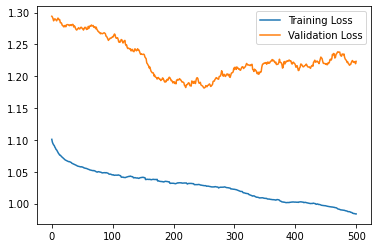

In [6]:
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'

with open(PICKLE_SAVE_PATH, 'rb') as f:
    H = pickle.load(f)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

n = 10
plt.plot(running_mean(H["train_loss"][::n*10],100))
plt.plot(running_mean(H["val_loss"][::n],100))
plt.legend(['Training Loss', 'Validation Loss'])

In [7]:
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/'

MODEL_NAME = "TFmaskfinal.pt"
model = TransformerMaskNet().cpu()
model.load_state_dict(torch.load(MODEL_SAVE_PATH+MODEL_NAME),strict=False)
model.eval()

TransformerMaskNet(
  (tdnn): Conv1d(1, 256, kernel_size=(16,), stride=(8,), padding=(6,))
  (lnorm): LayerNorm((6250,), eps=1e-05, elementwise_affine=True)
  (lin0): Linear(in_features=256, out_features=256, bias=True)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln21): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln31): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln32): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln41): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln42): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (mha2): MultiheadAttention(
 

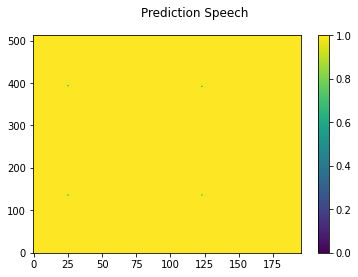

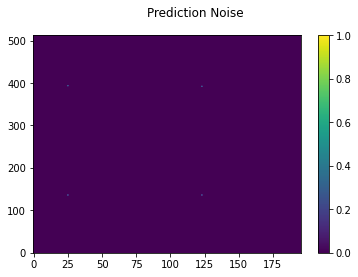

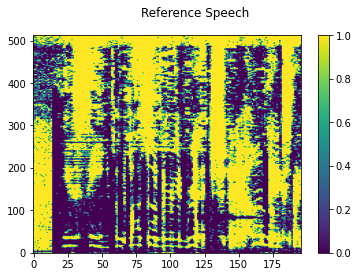

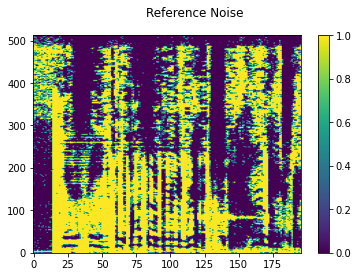

In [8]:
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = model(X[e_nr]).float()
    speech_pred = (speech_pred>0.5).float()
    noise_pred = torch.ones([513,196])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

# STFT
N_FFT = 1024
N_HOP = 256
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

evaluate_example(30)

In [56]:
def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred).type(torch.complex128)
        psd_noise = psd_transform(mix[i], noise_pred).type(torch.complex128)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i].type(torch.complex128), psd_speech, psd_noise,reference_channel=0)
        waveform_souden = istft(stft_souden, length=50000)#X[i].shape[-1])
        return waveform_souden

In [59]:
model.eval()
i = 300
speech_pred = model(X[i]).float()
noise_pred = torch.ones([513,196])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X,i).type(torch.float32)

torchaudio.save("./outputs/sample_model_mix.wav",mix[i].reshape(1,-1),16000)
torchaudio.save("./outputs/sample_model_ref.wav",speech[i].reshape(1,-1),16000)
torchaudio.save("./outputs/sample_model_output.wav",wave.reshape(1,-1),16000)